In [ ]:
!pip install --user -U torchsummary tqdm sentence-transformers tokenizers pyLDAvis

In [11]:
import joblib
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import csv
import gensim

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn.init as init
from torch.nn.utils.rnn import pad_sequence

import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from gensim.models import KeyedVectors
from gensim import corpora

import matplotlib.pyplot as plt
import seaborn as sns

import multiprocessing as mp

torch.set_num_threads(mp.cpu_count())

# Set the aesthetics for the plots
sns.set(style="whitegrid")

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Ensure necessary NLTK data is downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
# nltk.download('vader_lexicon')

TRAIN_SMALL = "./etc/training_small.csv"
TRAIN_LARGE = "./etc/training_large.csv"
TEST = "./etc/test.csv"

FEATURES = ["overall_rating", "headline", "pros", "cons"]

char_pairs = [('â\x80\x99', "'"), ('â\x80\x9c', '"'), ('â\x80\x9d', "\""), ('â\x80¦', ','),
                  ('â\x80\x94', '-'), ('â\x80\x98', "'"), ("\'", "'"), ('\r', " ")]

STOP_WORDS = set(stopwords.words('english'))
LEMMATIZER = WordNetLemmatizer()
REMOVE_PUNCT_DICT = str.maketrans('', '', string.punctuation)

BATCH_SIZE = 16
EMBEDDING_LENGTH = 100 # * 3
INPUT_LENGTH = 3 * EMBEDDING_LENGTH
PCA_COMPONENTS = 150

[nltk_data] Downloading package punkt to /home/a8kar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/a8kar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/a8kar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
def load_glove_model(glove_model_name: str):
    glove_text_file = f"./etc/{glove_model_name}.txt"
    glove_binary_file = f"./etc/{glove_model_name}.bin"
    
    # Check if the binary file already exists
    if os.path.exists(glove_binary_file):
        print("Loading from binary file...")
        model = KeyedVectors.load_word2vec_format(glove_binary_file, binary=True)
    else:
        print("Loading from text file. This might take a while...")
        model = KeyedVectors.load_word2vec_format(glove_text_file, binary=False, no_header=True)
        print("Saving binary file for future use...")
        model.save_word2vec_format(glove_binary_file, binary=True)
    
    return model

# Load model
GLOVE_MODEL_NAME = "glove.6B.100d"
glove_model = load_glove_model(GLOVE_MODEL_NAME)
print("Done.")

Loading from binary file...
Done.


In [3]:
def save_data_to_csv(data, file_names, label_column=False):
    for dataset, file_name in zip(data, file_names):
        df = pd.DataFrame(dataset)
        if label_column:
            df.columns = ['overall_rating']
        df.to_csv(f'./etc/{file_name}.csv', index=False)

def get_glove_embedding(text, model):    
    if not isinstance(text, str) or pd.isna(text):
        return np.zeros(model.vector_size)

    words = word_tokenize(text)
    embeddings = [model[word] for word in words if word in model.key_to_index]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(model.vector_size)

def save_combined_embeddings(cur_df, file_path, model):
    combined_embeddings = []

    try:
        for i in range(0, len(cur_df), 2000):
            batch = cur_df[i:i+2000]
            for j in range(len(batch)):
                # Generate GloVe embeddings for each text section
                pros_emb = get_glove_embedding(batch.iloc[j]["pros"], model)
                cons_emb = get_glove_embedding(batch.iloc[j]["cons"], model)
                headline_emb = get_glove_embedding(batch.iloc[j]["headline"], model)

                # Concatenate embeddings and sentiment scores
                concatenated_emb = np.hstack((
                    pros_emb,
                    cons_emb,
                    headline_emb,
                ))
                combined_embeddings.append(concatenated_emb)

        final_embeddings_np = np.vstack(combined_embeddings)
        np.save(file_path, final_embeddings_np)

    except Exception as e:
        print("ERROR: ", e)

def generate_embedding(
    features=["pros", "cons", "headline"],
    embedding_file_name="./etc/embeddings_large_cleaned.npy"
):
    print("Generating embeddings using ", embedding_file_name)
    embedding = np.load(embedding_file_name)
    
    # Length of one embedding vector is 300
    len_embedding_vector = len(embedding[0])
    assert len_embedding_vector == INPUT_LENGTH
    
    print("Embedding size: ", len_embedding_vector)

    train_embeddings = []

    for i, cur_feature in enumerate(features):
        # Extract embeddings
        start_index = i * len_embedding_vector
        end_index = start_index + len_embedding_vector
        train_embeddings.append(embedding[:, start_index:end_index])

    all_data_embedding = np.concatenate(train_embeddings, axis=1)
    return all_data_embedding


def preprocess_text(text):
    # Convert to lowercase    
    text = text.lower().translate(REMOVE_PUNCT_DICT)
    
    # Clean special characters
    for old_char, new_char in char_pairs:
        text = text.replace(old_char, new_char)
    
    # Tokenization and Stopword Removal
    tokens = [word for word in word_tokenize(text) if word not in STOP_WORDS]

    # Lemmatization
    return ' '.join([LEMMATIZER.lemmatize(word) for word in tokens])

def preprocess(df, model, large:bool = False, get_embeddings: bool = False, clean: bool = True, save: bool = True):
    df = df[FEATURES]
    d = "large" if large else "small"
    
    if clean:
        print("Cleaning...")

        # Replace empty strings with NaN
        df.replace(["", " "], np.nan, inplace=True)

        # Text preprocessing
        for col in ["pros", "cons", "headline"]:
            df[col] = df[col].astype(str).apply(preprocess_text)

        print("Cleaning done. Saving CSV...")
        df.to_csv(f"./etc/df_cleaned_{d}.csv")
        print("Saved.")
    else:
        print("Using pre-cleaned dataset...")
        df = pd.read_csv(f"./etc/df_cleaned_{d}.csv")
    
    embedding_file_name = f"./etc/embeddings_{d}_cleaned_100d.npy"

    if get_embeddings:
        print(f"Generating embedding file with {d} dataset...")
        save_combined_embeddings(df, embedding_file_name, model)
        print("Generated embedding file.")
    
    # Generate embeddings
    all_data_embedding = generate_embedding(embedding_file_name=embedding_file_name)

    # Need this to use CrossEntropyLoss because now it's a categorization problem
    ratings = df["overall_rating"] - 1
    
    print("df: ", df.shape)
    print("all_data_embedding: ", len(all_data_embedding))
    print("ratings: ", ratings.shape)
    
    print("Splitting...")
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(all_data_embedding, ratings, test_size=0.2, random_state=42)
    
    # Get a validation set
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
    
    # Perform PCA to find most relevant features
    pca = PCA(n_components=PCA_COMPONENTS)
    print("Preprocessing X_train")
    X_train = pca.fit_transform(X_train)
    print("Preprocessing X_val")
    X_val = pca.transform(X_val)
    print("Preprocessing X_test")
    X_test = pca.transform(X_test)

    # Save the fitted PCA object
    print("Finished preprocessing. Saving PCA object...")
    joblib.dump(pca, './etc/trained_pca_v4.joblib')
    print("Saved PCA object.")

    sc = StandardScaler()
    print("Scaling X_train")
    X_train = sc.fit_transform(X_train)
    print("Scaling X_val")
    X_val = sc.fit_transform(X_val)
    print("Scaling X_test")
    X_test = sc.transform(X_test)

    # And the SC object
    print("Finished scaling. Saving SC object...")
    joblib.dump(sc, './etc/trained_sc_v4.joblib')
    print("Saved SC object.")
    
    print("*** Finished preprocessing. ***")
    
    print(f"X_train: {X_train.shape}; y_train: {y_train.shape}")
    print(f"X_val: {X_val.shape}; y_val: {y_val.shape}")
    print(f"X_test: {X_test.shape}; y_test: {y_test.shape}")
    
    if (save):
        print("Saving datasets...")
        save_data_to_csv([X_train, X_val, X_test], ['X_train_v4', 'X_val_v4', 'X_test_v4'])
        save_data_to_csv([y_train, y_val, y_test], ['y_train_v4', 'y_val_v4', 'y_test_v4'], label_column=True)
        print("Saved.")
    
    return X_train, X_val, X_test, y_train, y_val, y_test

def preprocess_test(df, clean: bool = True, generate_embeddings: bool = True):
    df = df[FEATURES]
    
    if (clean):
        # Clean
        print("Cleaning...")

        # Replace empty strings with NaN
        df.replace(["", " "], np.nan, inplace=True)

        # Text preprocessing
        for col in ["pros", "cons", "headline"]:
            df[col] = df[col].astype(str).apply(preprocess_text)

        print("Cleaning done. Saving CSV...")
        df.to_csv("./etc/df_test_cleaned_large.csv")
        print("Saved.")
    else:
        print("Reading from saved file.")
        df = pd.read_csv("./etc/df_test_cleaned_large.csv")
    
    embedding_file_name = f"./etc/embeddings_test_large_cleaned_100d.npy"
    
    if (generate_embeddings):
        print("Generating embeddings for test data")
        save_combined_embeddings(df, embedding_file_name, glove_model)
        print("Generated")
    
    # Generate embeddings
    all_data_embedding = generate_embedding(embedding_file_name=embedding_file_name)
    
    pca = joblib.load("./etc/trained_pca_v4.joblib")
    print("Doing PCA...")
    all_data_embedding = pca.fit_transform(all_data_embedding)
    print("PCA done")
    
    sc = joblib.load("./etc/trained_sc_v4.joblib")
    print("Scaling...")
    all_data_embedding = sc.fit_transform(all_data_embedding)
    print("Scaling done")
    
    print("*** Finished preprocessing. ***")
    
    print("len(all_data_embedding): ", len(all_data_embedding))
    
    return all_data_embedding

In [104]:
df = pd.read_csv(TRAIN_LARGE)
df = df[FEATURES]
df.head()

,overall_rating,headline,pros,cons
0,1,Good,close to my home which can save my transportat...,get less pay and drive you to die
1,4,Are you going to send this to Deloitte?,High standard and a lot of good people to work...,Doesn't consider human nature when make decisi...
2,3,"Big, slow and complex. A place to hide or a pl...",A recognizable name and fair to decent benefit...,Constant threat of layoffs. IBM is moving many...
3,4,Happy - for now.,Working with the latest technology and mature ...,The company has gotten so large - and is growi...
4,5,"stable company, fair compensation, great culture","Great benefits and work life balance. Also, c...",Very consensus oriented which can slow down pr...


In [105]:
# Preprocess the data
X_train, X_val, X_test, y_train, y_val, y_test = preprocess(df, model=glove_model, large=True, get_embeddings=False, clean=False, save=False)

# X_train = pd.read_csv("./etc/X_train_v4.csv")
# X_val = pd.read_csv("./etc/X_val_v4.csv")
# X_test = pd.read_csv("./etc/X_test_v4.csv")
# y_train = pd.read_csv("./etc/y_train_v4.csv")
# y_val = pd.read_csv("./etc/y_val_v4.csv")
# y_test = pd.read_csv("./etc/y_test_v4.csv")

print("Loaded data.") 

Using pre-cleaned dataset...
Generating embeddings using  ./etc/embeddings_large_cleaned_100d.npy
Embedding size:  300
df:  (553678, 5)
all_data_embedding:  553678
ratings:  (553678,)
Splitting...
Preprocessing X_train
Preprocessing X_val
Preprocessing X_test
Finished preprocessing. Saving PCA object...
Saved PCA object.
Scaling X_train
Scaling X_val
Scaling X_test
Finished scaling. Saving SC object...
Saved SC object.
*** Finished preprocessing. ***
X_train: (398647, 150); y_train: (398647,)
X_val: (44295, 150); y_val: (44295,)
X_test: (110736, 150); y_test: (110736,)
Loaded data.


In [4]:
from torch.nn.utils.rnn import pad_sequence

def df_to_seq(df):
    # Convert the DataFrame to a NumPy array for faster processing
    numpy_array = df.values
    
    # Convert each row in the NumPy array to a tensor
    tensor_array = [torch.tensor(row, dtype=torch.float32) for row in numpy_array]
    return pad_sequence(tensor_array, batch_first=True)

def to_seq(numpy_array):    
    # Convert each row in the NumPy array to a tensor
    tensor_array = [torch.tensor(row, dtype=torch.float32) for row in numpy_array]
    return pad_sequence(tensor_array, batch_first=True)

In [157]:
train_d = TensorDataset(to_seq(X_train), torch.tensor(y_train.values))
val_d = TensorDataset(to_seq(X_val), torch.tensor(y_val.values))
test_d = TensorDataset(to_seq(X_test), torch.tensor(y_test.values))

train_loader = DataLoader(train_d, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_d, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_d, batch_size=BATCH_SIZE, shuffle=False)
print("Done.")

Done.


In [158]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([16, 150])
Labels batch shape: torch.Size([16])


In [5]:
class MyNN(nn.Module):
    def __init__(self, input_size=100, hidden_size=200, output_size=5, dropout_prob=0.5):
        super(MyNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                # Initialize weights using Xavier initialization
                init.xavier_normal_(m.weight)
                init.constant_(m.bias, 0.0)
    
    def forward(self, x):
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.dropout(self.relu(self.fc3(x)))
        # x = self.dropout(self.relu(self.fc4(x)))
        x = self.output(x)
        return x

In [140]:
class MyNN2(nn.Module):
    def __init__(self, input_size=100, hidden_size=200, output_size=5, dropout_prob=0.25):
        super(MyNN2, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                # Initialize weights using Xavier initialization
                init.xavier_normal_(m.weight)
                init.constant_(m.bias, 0.0)
    
    def forward(self, x):
        x = self.dropout(self.tanh(self.fc1(x)))
        x = self.dropout(self.tanh(self.fc2(x)))
        x = self.dropout(self.tanh(self.fc3(x)))
        # x = self.dropout(self.relu(self.fc4(x)))
        x = self.output(x)
        return x

In [160]:
# Generic training function
def train_model(model, train_loader, val_loader, optimizer, loss_fn, epochs, device):
    model.to(device)
    train_acc_list, val_acc_list = [], []
    best_val_accuracy = 0  # For checkpointing

    print("Starting training...")
    for epoch in range(epochs):
        model.train()
        total_loss, correct_train, total_train = 0, 0, 0
        train_loss_list = []

        for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}'):
            features, labels = batch[0].to(device), batch[1].to(device)

            # Forward pass
            outputs = model(features)
            loss = loss_fn(outputs, labels)
            train_loss_list.append(loss.item())

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = sum(train_loss_list) / len(train_loss_list)
        train_accuracy = 100 * correct_train / total_train
        train_acc_list.append(train_accuracy)
        print(f'Training Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%')

        # Validation phase
        model.eval()
        val_loss_list, correct_val, total_val = [], 0, 0
        with torch.no_grad():
            for batch in val_loader:
                features, labels = batch[0].to(device), batch[1].to(device)

                outputs = model(features)
                loss = loss_fn(outputs, labels)
                val_loss_list.append(loss.item())

                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = sum(val_loss_list) / len(val_loss_list)
        val_accuracy = 100 * correct_val / total_val
        val_acc_list.append(val_accuracy)
        print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%')

        # Save the best model
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_model.pth')

    print("Training complete.")
    return model, train_acc_list, val_acc_list


def master_train(train_loader, val_loader, model_name: str = "mynn"):
    model_dict = {
        # "lstm": LSTMModel,
        # "bilstm": BiLSTMModel,
        # "gru": GRUModel,
        "mynn": MyNN,
        "mynn2": MyNN2,
    }
    
    # Common model parameters
    # embedding_dim = len(X_train.iloc[0])
    embedding_dim = 150 # PCA components
    hidden_dim = 200
    
    print(f"Embedding dimensions: {embedding_dim}. Hidden dimensions: {hidden_dim}")
    
    model = model_dict[model_name](embedding_dim, hidden_dim)
    
    # Common parameters for training
    EPOCHS = 5
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    
    print(f"Training for {EPOCHS} epochs...")
    return train_model(model, train_loader, val_loader, optimizer, loss_fn, EPOCHS, DEVICE)

In [ ]:
trained_model, training_acc, val_acc = master_train(train_loader, val_loader, model_name="mynn")
print("Done training")

Embedding dimensions: 150. Hidden dimensions: 200
Training for 5 epochs...
Starting training...


Epoch 1/5:   0%|          | 8/24916 [00:07<6:35:14,  1.05it/s]

In [36]:
torch.save(trained_model.state_dict(), "fc_model_2")

In [6]:
trained_model = MyNN(150, 200)
trained_model.load_state_dict(torch.load("./final_fc_model"))

<All keys matched successfully>

In [7]:
print(trained_model)

MyNN(
  (fc1): Linear(in_features=150, out_features=200, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=200, bias=True)
  (fc4): Linear(in_features=200, out_features=200, bias=True)
  (output): Linear(in_features=200, out_features=5, bias=True)
)


In [163]:
from sklearn.metrics import f1_score

# Assuming you have a model and test_loader
trained_model.eval()  # Set the model to evaluation mode

true_labels = []
predictions = []

print("Evaluating")
with torch.no_grad():  # Disable gradient computation
    for batch in test_loader:
        inputs, labels = batch
        outputs = trained_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        # predicted = predicted + 1
 
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print("Finished")

# Calculate F1 score for multi-class classification
f1_macro = f1_score(true_labels, predictions, average='macro')
f1_weighted = f1_score(true_labels, predictions, average='weighted')
f1_micro = f1_score(true_labels, predictions, average='micro')

print(f"Macro F1 Score: {f1_macro}")
print(f"Weighted F1 Score: {f1_weighted}")
print(f"Micro F1 Score: {f1_micro}")

Evaluating
Finished
Macro F1 Score: 0.1785560173311595
Weighted F1 Score: 0.26381542980627287
Micro F1 Score: 0.3632874584597601


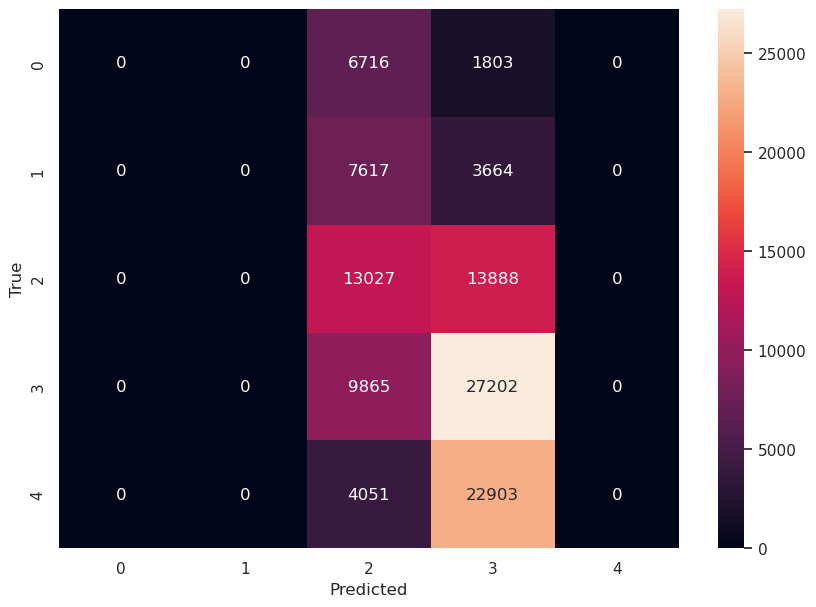

In [165]:
# Confusion  matrix for training data
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plotting the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig("./img/q2_cm.png")
plt.show()

In [145]:
FINAL_TEST = "./etc/final_test.csv"
final_test = pd.read_csv(FINAL_TEST)
final_test = preprocess_test(final_test, False, False)

# Create data loader
final_test_loader = DataLoader(to_seq(final_test), batch_size=BATCH_SIZE, shuffle=False)

Reading from saved file.
Generating embeddings using  ./etc/embeddings_test_large_cleaned_100d.npy
Embedding size:  300
Doing PCA...
PCA done
Scaling...
Scaling done
*** Finished preprocessing. ***
len(all_data_embedding):  56976


In [146]:
# Generate predictions for Q1
trained_model.eval()  # Ensure the model is in evaluation mode

with torch.no_grad(), open('q1_predictions.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['overall_rating'])

    for inputs in final_test_loader:
        outputs = trained_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        predicted = predicted + 1

        for pred in predicted:
            writer.writerow([pred.item()])

print("Predictions saved to predictions.csv.")

Predictions saved to predictions.csv.


In [149]:
d = pd.read_csv("q1_predictions.csv")
d["overall_rating"].unique()

array([3, 4])

# Plots
**Acknowledgement:** The code for the feature importances, correlation matrix, and T-SNE distributions was adapted from "Doraemon"'s provided code on LEARN with certain changes as necessary.

## Plot 1: Feature importances

In [ ]:
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, Subset

def permutation_importance(model, dataset, loader, metric, device, subset_size=10000):
    model.eval()
    original_score, n_features = 0, 0
    feature_importance = []

    # Create a subset of the original dataset
    subset_indices = np.random.choice(len(dataset), subset_size, replace=False)
    subset_dataset = Subset(dataset, subset_indices)

    # Create a DataLoader for the subset
    subset_loader = DataLoader(subset_dataset, batch_size=loader.batch_size, shuffle=False)

    # Get the score with the original dataset
    for batch in tqdm(subset_loader):
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        original_score += metric(labels.cpu().numpy(), outputs.detach().cpu().numpy().argmax(axis=1))

    original_score /= len(subset_loader)
    
    # Permute each feature (time step) and get new score
    for feature_idx in tqdm(range(inputs.size(1))):
        perturbed_score = 0
        for batch in subset_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            # Permute the entire batch at once
            permuted_idx = torch.randperm(inputs.size(0))
            inputs[:, feature_idx] = inputs[permuted_idx, feature_idx]
            outputs = model(inputs)
            perturbed_score += metric(labels.cpu().numpy(), outputs.detach().cpu().numpy().argmax(axis=1))

        perturbed_score /= len(subset_loader)
        feature_importance.append(original_score - perturbed_score)

    return np.array(feature_importance)

# Example usage
importances = permutation_importance(trained_model, train_d, train_loader, accuracy_score, DEVICE, subset_size=10000)

plt.figure(figsize=(12, 6))
plt.bar(range(len(importances)), importances)
plt.xlabel('Feature (Time Step)')
plt.ylabel('Importance')
plt.title('Permutation Importance for Each Time Step in LSTM')
plt.savefig("./img/q2_feature_importances.png")
plt.show()

In [23]:
embeddings_training = np.load("./etc/embeddings_large_cleaned_100d.npy")
embeddings_testing = np.load("./etc/embeddings_test_large_cleaned_100d.npy")
num_features = 3
len_per_embedding = int(len(embeddings_training[0]) / num_features)

In [ ]:
pca = joblib.load("./etc/trained_pca_v4.joblib")

new_train_embedding = {}
for key in train_embeddings:
    print(f"Done {key}")
    pca = PCA(n_components=20)
    new_train_embedding[key] = pca.fit_transform(train_embeddings[key])

individual_feature_f1  = {}
actual_val = df["overall_rating"].values[:200000]

def generate_split(embeddings):
    SPLIT = 120000
    return embeddings[:SPLIT], actual_val[:SPLIT], embeddings[SPLIT:], actual_val[SPLIT:]

X_train, Y_train, X_test, Y_test = generate_split(new_train_embedding["pros"])

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Compute baseline accuracy
for feature in new_train_embedding:
    model = RandomForestClassifier(n_estimators=50, n_jobs=10, verbose=1)
    individual_feature_f1[feature] = np.mean(
        cross_val_score(model, new_train_embedding[feature], actual_val, cv=2, scoring='accuracy')
    )

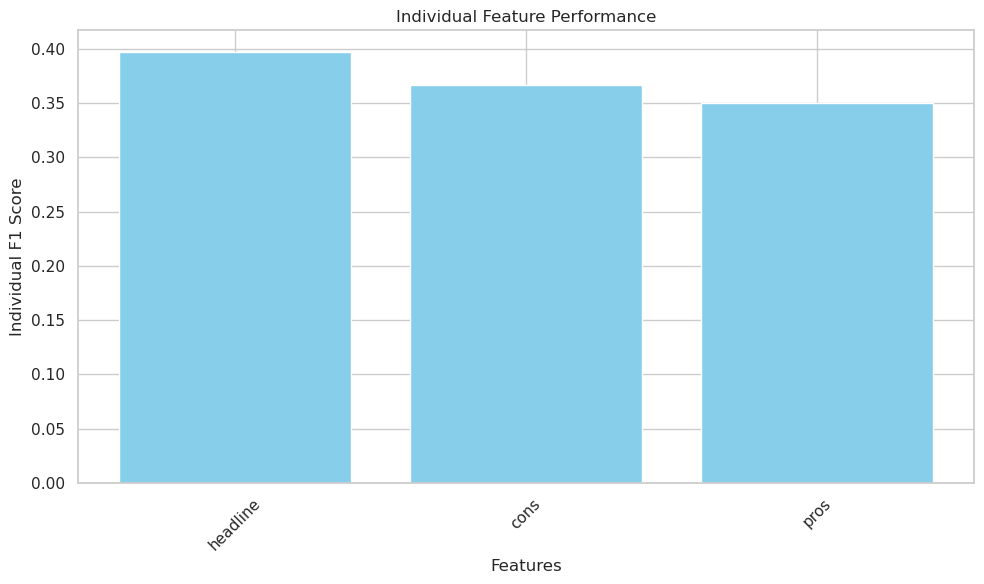

In [26]:
# Sorting the dictionary by values in descending order
sorted_data = sorted(individual_feature_f1.items(), key=lambda x: x[1], reverse=True)
categories = [x[0] for x in sorted_data]
values = [x[1] for x in sorted_data]

# Plotting the sorted bar graph
plt.figure(figsize=(10, 6))
plt.bar(categories, values, color='skyblue')
plt.xlabel('Features')
plt.ylabel('Individual F1 Score')
plt.title('Individual Feature Performance')
plt.xticks(rotation=45) # Rotating x-axis labels for better readability if needed
plt.tight_layout()
plt.savefig("./img/q2_feature_importance.png")
plt.show()

## Plot 2: Correlation between features

In [18]:
embeddings_training = np.load("./etc/embeddings_large_cleaned_100d.npy")
embeddings_testing = np.load("./etc/embeddings_test_large_cleaned_100d.npy")
num_features = 3
len_per_embedding = int(len(embeddings_training[0]) / num_features)

Processing pros, cons
Processing pros, headline
Processing cons, headline


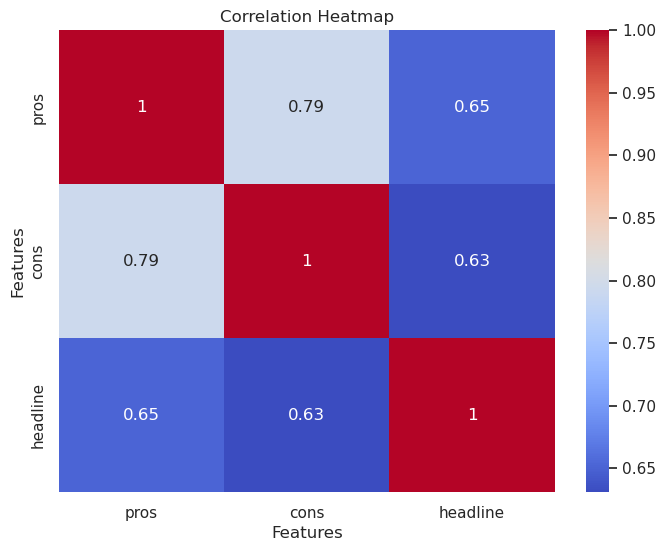

In [22]:
from sklearn.decomposition import PCA
from scipy.spatial.distance import cosine
import torch.nn.functional as F
import itertools
from numpy.linalg import norm

# Example: Generating multiple sets of embeddings (replace these with your actual embeddings)
num_embeddings = 200000
embedding_length = 30

# Generating three different sets of embeddings
embedding_names = [
    'pros',
    'cons',
    'headline',
]
train_embeddings = {}
for i, name in enumerate(embedding_names):
    train_embeddings[name] = embeddings_training[:, i * len_per_embedding: (i+1) * len_per_embedding][:num_embeddings]

def compute_embedding_wide_cosine_similarity(embeddings_1, embeddings_2, chunk_size=1000):
    # Convert to PyTorch tensors if they aren't already
    embeddings_1 = torch.tensor(embeddings_1)
    embeddings_2 = torch.tensor(embeddings_2)
    
    # Compute similarities in chunks to save memory
    num_embeddings = embeddings_1.shape[0]
    similarities = []
    for i in range(0, num_embeddings, chunk_size):
        chunk_embeddings_1 = embeddings_1[i:i+chunk_size]
        chunk_embeddings_2 = embeddings_2[i:i+chunk_size]
        
        # Normalize the embeddings so that they are unit vectors
        chunk_embeddings_1_norm = torch.nn.functional.normalize(chunk_embeddings_1, p=2, dim=1)
        chunk_embeddings_2_norm = torch.nn.functional.normalize(chunk_embeddings_2, p=2, dim=1)

        # Compute cosine similarity as dot product of normalized vectors
        chunk_cosine_similarity = torch.mm(chunk_embeddings_1_norm, chunk_embeddings_2_norm.transpose(0, 1))
        
        # Store the computed similarities
        similarities.append(chunk_cosine_similarity)

    # Concatenate all the computed similarities and calculate the mean
    all_similarities = torch.cat(similarities, dim=0)
    return torch.mean(all_similarities).item()

similarity_score = {}
for name1, name2 in itertools.combinations(embedding_names, 2):
    print(f"Processing {name1}, {name2}")
    val = compute_embedding_wide_cosine_similarity(
        train_embeddings[name1],
        train_embeddings[name2]
    )
    similarity_score[(name1, name2)] = val
    similarity_score[(name2, name1)] = val

for name in embedding_names:
    similarity_score[(name, name)] = 1

# Create an empty correlation matrix
num_columns = len(embedding_names)
correlation_matrix = np.zeros((num_columns, num_columns))

# Fill the correlation matrix using the dictionary values
for i, column1 in enumerate(embedding_names):
    for j, column2 in enumerate(embedding_names):
        if (column1, column2) in similarity_score:
            correlation_matrix[i, j] = similarity_score[(column1, column2)]
        elif (column2, column1) in similarity_score:
            correlation_matrix[i, j] = similarity_score[(column2, column1)]

# Create a heatmap using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, xticklabels=embedding_names, yticklabels=embedding_names, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.xlabel('Features')
plt.ylabel('Features')
plt.savefig("./img/q2_correlations.png")
plt.show()

## Plot 3: Distribution of features in training vs test sets

In [28]:
num_embeddings = 5000
embedding_length = 30

# Generating three different sets of embeddings
train_embeddings = []
for i in range(num_features):
    train_embeddings.append(embeddings_training[:, i * len_per_embedding: (i+1) * len_per_embedding][:num_embeddings])

test_embeddings = []
for i in range(num_features):
    test_embeddings.append(embeddings_testing[:, i * len_per_embedding: (i + 1)* len_per_embedding][:num_embeddings])

all_embeddings = np.vstack(train_embeddings + test_embeddings)

# Reduce dimension using PCA
pca = PCA(n_components=embedding_length)
pca.fit(all_embeddings)

all_embeddings = pca.fit_transform(all_embeddings)
print(len(all_embeddings))
print(len(all_embeddings[0]))

30000
30


In [29]:
from sklearn.manifold import TSNE

# Combine all embeddings and assign labels for color coding
labels = []
for i in range(int(len(all_embeddings)/num_embeddings)):
    labels += [i] * num_embeddings

labels = np.array(labels)
# Perform t-SNE dimensionality reduction to 2D
tsne = TSNE(n_components=2, n_jobs=10, verbose=1)
embeddings_2d = tsne.fit_transform(all_embeddings)

/srv/jupyter_python3-extra/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/srv/jupyter_python3-extra/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 30000 samples in 0.002s...
[t-SNE] Computed neighbors for 30000 samples in 2.882s...
[t-SNE] Computed conditional probabilities for sample 1000 / 30000
[t-SNE] Computed conditional probabilities for sample 2000 / 30000
[t-SNE] Computed conditional probabilities for sample 3000 / 30000
[t-SNE] Computed conditional probabilities for sample 4000 / 30000
[t-SNE] Computed conditional probabilities for sample 5000 / 30000
[t-SNE] Computed conditional probabilities for sample 6000 / 30000
[t-SNE] Computed conditional probabilities for sample 7000 / 30000
[t-SNE] Computed conditional probabilities for sample 8000 / 30000
[t-SNE] Computed conditional probabilities for sample 9000 / 30000
[t-SNE] Computed conditional probabilities for sample 10000 / 30000
[t-SNE] Computed conditional probabilities for sample 11000 / 30000
[t-SNE] Computed conditional probabilities for sample 12000 / 30000
[t-SNE] Computed conditional probabilities for sam

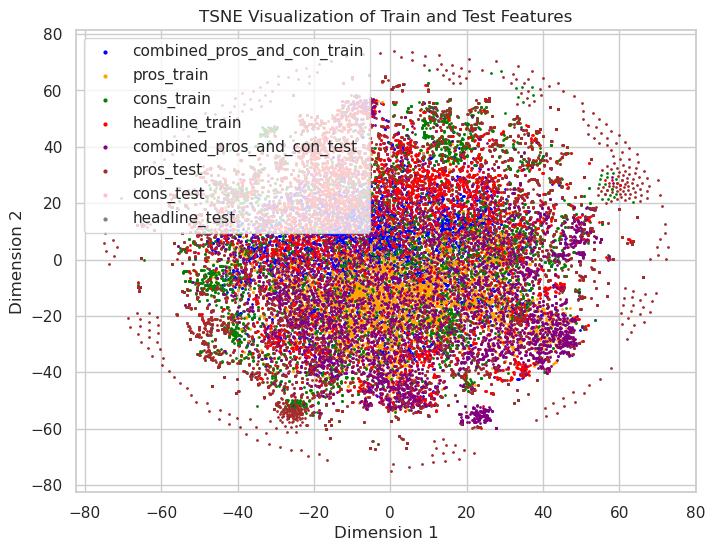

In [33]:
# Define unique colors for each set of embeddings
colors = [
    ('blue', 'combined_pros_and_con_train'),
    ('orange', 'pros_train'),
    ('green', 'cons_train'),
    ("red", 'headline_train'),
    ('purple', 'combined_pros_and_con_test'),
    ('brown', 'pros_test'),
    ('pink', 'cons_test'),
    ("gray", 'headline_test'),
]

# Visualize the embeddings in 2D with unique color coding for each set
plt.figure(figsize=(8, 6))
for i, (color, label) in enumerate(colors):
    indices = np.where(labels == i)
    plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], s=1, c=color, label=label)
    

plt.title('TSNE Visualization of Train and Test Features')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.legend(markerscale=2)
plt.grid(True)
plt.savefig("./img/q2_distribution_combined.png")
plt.show()

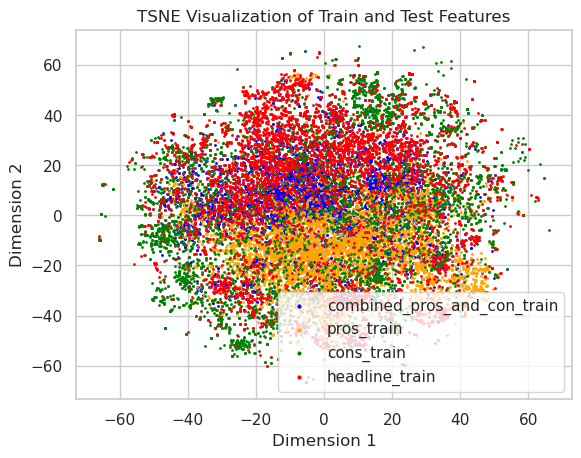

In [37]:
for i, (color, label) in enumerate(colors):
    if (i >= 4):
        break
    indices = np.where(labels == i)
    plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], s=1, c=color, label=label)

plt.title('TSNE Visualization of Train and Test Features')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.legend(markerscale=2)
plt.grid(True)
plt.savefig("./img/q2_distribution_train.png")
plt.show()

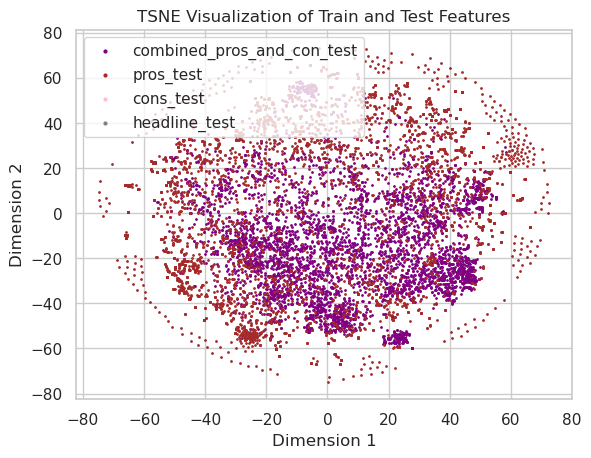

In [36]:
for i, (color, label) in enumerate(colors):
    if (i < 4):
        continue
    indices = np.where(labels == i)
    plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], s=1, c=color, label=label)

plt.title('TSNE Visualization of Train and Test Features')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.legend(markerscale=2)
plt.grid(True)
plt.savefig("./img/q2_distribution_test.png")
plt.show()

## Plot 4: Distribution of residuals

In [ ]:
# Assuming test_loader is your DataLoader for the test set
# and lstm_model is your trained LSTM model
trained_model.eval()  # Set the model to evaluation mode

actuals = []
predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = trained_model(inputs)
        
        # Assuming a regression task, adjust if it's classification
        predicted_ratings = outputs.squeeze().cpu().numpy()
        actual_ratings = labels.cpu().numpy()
        
        actuals.extend(actual_ratings)
        predictions.extend(predicted_ratings)

# Convert to numpy arrays
actuals = np.array(actuals)
predictions = np.argmax(np.array(predictions), axis=1)

errors = [0] * 5
for i in range(len(actuals)):
    if actuals[i] != predictions[i]:
        errors[actuals[i]] += 1
        
plt.bar(list(range(1, 6)), errors)
plt.xlabel("Rating")
plt.ylabel("Number of errors")
plt.savefig("./img/q2_error_dist.png")
plt.show()

## Plot 5: Weight visualization of the first layer

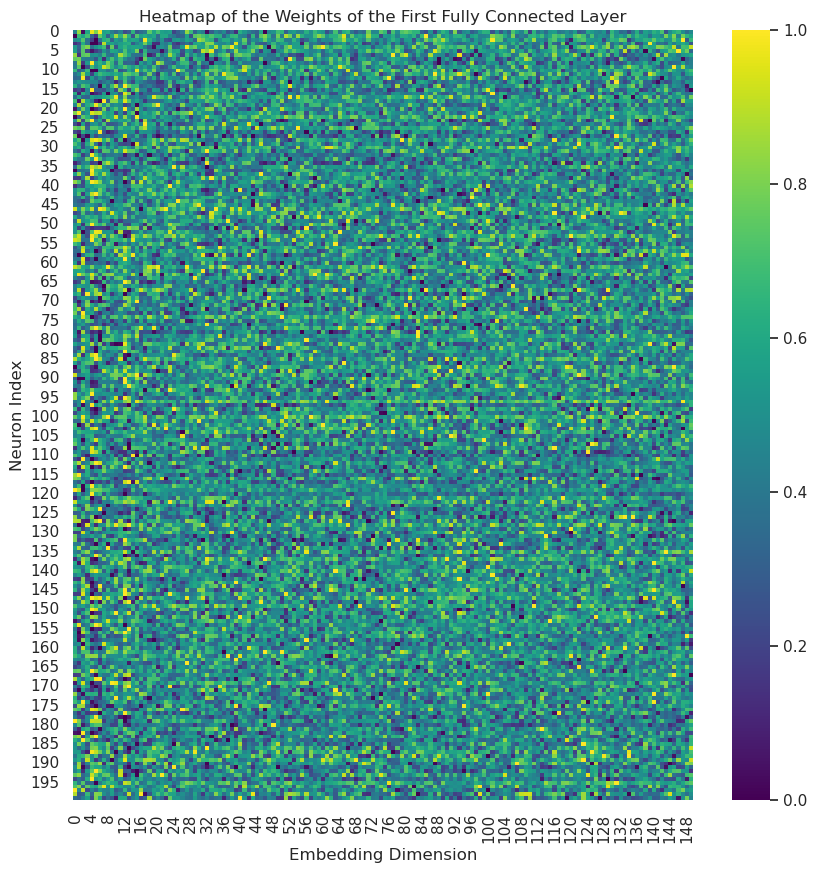

In [62]:
# Extract the weights of the first fully connected layer
weights = trained_model.fc1.weight.data.cpu().numpy()

# Normalize the weights for better visualization
weights_norm = weights - weights.min(axis=1, keepdims=True)
weights_norm = weights_norm / weights_norm.max(axis=1, keepdims=True)

# Plotting the weights as a heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(weights_norm, cmap='viridis')
plt.title('Heatmap of the Weights of the First Fully Connected Layer')
plt.xlabel('Embedding Dimension')
plt.ylabel('Neuron Index')
plt.savefig("./img/q2_neuron.png")
plt.show()

# Q3
Perform LDA (Latent Dirichlet Analysis) to find commonly occuring words/phrases in reviews with less than 4 stars.

In [8]:
data = pd.read_csv("./etc/df_cleaned_large.csv")
data = data[FEATURES]
data.head()

,overall_rating,headline,pros,cons
0,1,good,close home save transportation cost,get le pay drive die
1,4,going send deloitte,high standard lot good people work,doesnt consider human nature make decision
2,3,big slow complex place hide place gain experie...,recognizable name fair decent benefit plus ibm...,constant threat layoff ibm moving many job off...
3,4,happy,working latest technology mature development p...,company gotten large growing head count breakn...
4,5,stable company fair compensation great culture,great benefit work life balance also company c...,consensus oriented slow progress create seemin...


In [72]:
low_ratings = data[data["overall_rating"] < 3]
low_ratings.dropna(subset=['cons'], inplace=True)

print("Splitting")

doc_clean = [str(doc).split() for doc in low_ratings["cons"].values]

print("Tokenized")

# Creating the term dictionary of our corpus, where every unique term is assigned an index
dictionary = corpora.Dictionary(doc_clean)

print("Created dictionary")

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

# print("Creating LDA model...")

# Creating the LDA model
# ldamodel = gensim.models.ldamodel.LdaModel(doc_term_matrix, num_topics=3, id2word = dictionary, passes=50, workers=4)
# ldamodel = gensim.models.ldamulticore.LdaMulticore(
#     doc_term_matrix, num_topics=3, id2word=dictionary, passes=10, workers=4, chunksize=2000
# )

# # Print the topics
# for idx, topic in ldamodel.print_topics(-1):
#     print('Topic: {} \nWords: {}'.format(idx, topic))

/tmp/ipykernel_77271/3433217993.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_ratings.dropna(subset=['cons'], inplace=True)


Splitting
Tokenized
Created dictionary


In [ ]:
joblib.dump(ldamodel, "./etc/ldamodel.joblib")

In [82]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Example with scikit-learn
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
data_vectorized = vectorizer.fit_transform(low_ratings["cons"])

num_topics = 10

lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=0)
lda_model.fit(data_vectorized)

LatentDirichletAllocation(random_state=0)

In [ ]:
def display_topics(model, feature_names, no_top_words):
    result = []
    for topic_idx, topic in enumerate(model.components_):
        result.append(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
    return result

num_topics = 3
results = {}

for rating in range(1, 6):
    print(f"Processing ratings of {rating} star(s)")
    temp_df = data[data["overall_rating"] == rating]
    temp_df.dropna(subset=['cons'], inplace=True)

    vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
    data_vectorized = vectorizer.fit_transform(temp_df["cons"])

    lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=0)
    lda_model.fit(data_vectorized)
    
    results[rating] = display_topics(lda_model, vectorizer.get_feature_names(), 10)
    
print("Done.")

In [89]:
joblib.dump(results, "./etc/lda_results.joblib")
for k, v in results.items():
    print(k)
    print(v)
    print('-' * 50)

1
['management company work employee people year culture team good career', 'work manager time like people dont company day job make', 'management staff work pay hour manager employee poor customer training']
--------------------------------------------------
2
['work manager time hour job staff day like dont people', 'company people employee management year manager team good job business', 'management work poor pay lack low balance hour long life']
--------------------------------------------------
3
['work hour pay long salary low balance life time working', 'company year employee people job lot level slow change career', 'management manager people team time employee lack customer staff like']
--------------------------------------------------
4
['company change process slow management lot growth career big time', 'work hour long time salary balance pay life working low', 'management people manager work good job dont team employee really']
--------------------------------------------

In [98]:
from torchsummary import summary
print(trained_model)

MyNN(
  (fc1): Linear(in_features=150, out_features=200, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=200, bias=True)
  (fc4): Linear(in_features=200, out_features=200, bias=True)
  (output): Linear(in_features=200, out_features=5, bias=True)
)


In [10]:
FINAL_TEST_PATH = "./etc/final_test_data.csv"
final_test_data = pd.read_csv(FINAL_TEST_PATH)
# final_test_data = preprocess_test(final_test_data, False, False)

final_test_data.head()

,3
0,5
1,5
2,5
3,3
4,4


In [ ]:

# Create data loader
final_test_loader = DataLoader(to_seq(final_test_data), batch_size=BATCH_SIZE, shuffle=False)
print("Done.")

In [16]:
from sklearn.metrics import f1_score

data = pd.read_csv("./q1_predictions.csv")

(56975, 1)

In [18]:
import csv

# Define the correct headers
headers = ['overall_rating']  # Replace with your actual headers

# Read the CSV file without treating the first row as a header
with open('./etc/final_test_data.csv', 'r') as file:
    reader = csv.reader(file)
    rows = list(reader)

# Write the corrected data to a new CSV file
with open('corrected_file.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(headers)  # Write the correct headers
    writer.writerows(rows)    # Write all rows including the original first row
    
t = pd.read_csv("corrected_file.csv")
t.head()

,overall_rating
0,3
1,5
2,5
3,5
4,3


In [20]:
answers = pd.read_csv("corrected_file.csv")
answers.shape

(56976, 1)

In [21]:
true_labels = answers["overall_rating"].values
predictions = data["overall_rating"].values


# Calculate F1 score for multi-class classification
f1_macro = f1_score(true_labels, predictions, average='macro')
f1_weighted = f1_score(true_labels, predictions, average='weighted')
f1_micro = f1_score(true_labels, predictions, average='micro')

print(f"Macro F1 Score: {f1_macro}")
print(f"Weighted F1 Score: {f1_weighted}")
print(f"Micro F1 Score: {f1_micro}")

Macro F1 Score: 0.14964593823198508
Weighted F1 Score: 0.21028200133795688
Micro F1 Score: 0.30146026397079473


In [23]:
acc = 0
for i, v in enumerate(answers["overall_rating"].values):
    if (v == data["overall_rating"].values[i]):
        acc += 1
        
l = len(answers["overall_rating"].values)
print(f"Accuracy: {acc / l}")

Accuracy: 0.30146026397079473
